### Downloading the data

In [1]:
from main import main
key = '<replace with your key>' # this is the key for the weather data API

In [2]:
# uncomment this line at your own risk
# it will take ~15-20 minutes to download the data and to do some cleaning
# main(key)

In [3]:
from configs import merged_cycle_data_file
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV

### Load the weather & holiday data

In [4]:
from configs import weather_data_csv

holidays = 'holidays.csv'
hol_df = pd.read_csv(holidays, index_col='date', parse_dates=['date'])
# get a set of the holiday dates
hol_set= set(hol_df.index.map(lambda x: x.date()))

# uncomment the lines below if you have downloaded the data using the scripts
# weather_df = pd.read_csv(weather_data_csv, index_col='timestamp', parse_dates=['timestamp'])
# weather_df.head()

### Load the merged csv file by reading it in chunks

# Warning:
The next cell takes a lot of time (it took 5h 10 mins for us) so uncomment this cell at your own risk.

In [5]:
# %%time
# from datetime import datetime
# import time

# chunk_size = 500000
# date_mapper = lambda x: pd.to_datetime(datetime(year=x.year, month=x.month, day=x.day, hour=x.hour))

# bike_share_df = pd.DataFrame()
# print('Started loading merged_cycle_data_file.')
# iter_ = pd.read_csv(merged_cycle_data_file, chunksize=chunk_size, iterator=True,
#         index_col='Rental Id',
#         parse_dates=['End Date', 'Start Date'])
# print('Finished loading merged_cycle_data_file.')

# r_start = time.time()
# for i, df in enumerate(iter_):
#     r_end = time.time()
#     print(f'{i+1}. Read rows {chunk_size*i}:{chunk_size*(i+1)} in {r_end-r_start:.3f}. ', end='')

#     start = time.time()
#     df = df.dropna()
#     # leave only entries that have valid duration
#     df = df[df['Duration'] > 0]
    
#     diff = df['End Date'] - df['Start Date'] # compute the difference between the objects
#     seconds = diff.map(lambda x: x.total_seconds()) # map to seconds
#     df = df[(df['Duration'] == seconds) & (seconds >= 0)] # check if duration matches the result and if the result is positive
    
    
#     # keep only year, month, day, hour information from the start date
#     df['Start Date'] = df['Start Date'].map(date_mapper)
#     # count the number of shares per hour
#     share_df = df.groupby('Start Date').agg({'Start Date': 'count'}).rename(columns={'Start Date': 'share_count'})
#     # join of weather data
#     share_df = share_df.join(weather_df)
#     # reset index
#     share_df = share_df.reset_index().rename(columns={'index': 'Start Date'})
#     share_df = share_df.dropna()
    
#     share_df['month'] = share_df['Start Date'].apply(lambda t: t.month)
#     share_df['weekday'] = share_df['Start Date'].apply(lambda t: t.weekday())
#     share_df['hour'] = share_df['Start Date'].apply(lambda t: t.hour)
#     share_df['is_holiday'] = share_df['Start Date'].map(lambda x: x.date() in hol_set).map(lambda x: '1' if x else '0')
#     # check if start date hits on a weekend
#     # monday is 0, sunday is 6
#     share_df['is_weekend'] = share_df['Start Date'].map(lambda x: x.weekday() > 4).map(lambda x: '1' if x else '0')
#     share_df['weatherCode'] = share_df['weatherCode'].map(lambda x: str(int(x)))
    
#     bike_share_df = bike_share_df.append(share_df)
#     end = time.time()
#     print(f'Completed cleaning & merging in {end-start:3.3f} seconds.')
#     r_start = time.time()

# print('Finished reading!')
# # bike_share_df = bike_share_df.reset_index(drop=True)
# # because of reading in chunks, some hours appear multiple times
# print('Grouping the hours')
# share_total = bike_share_df.groupby('Start Date').agg({'share_count': 'sum'})
# share_row = bike_share_df.groupby('Start Date').agg(lambda x: x.iloc[0])
# share_row['share_count'] = share_total['share_count']
# bike_share_df = share_row.reset_index()
# print('Saving to file')
# # save the data to a file, so that we can load it faster next time
# bike_share_df.sort_values('Start Date').reset_index(drop=True).to_csv('bike-shares.csv', index=False)

In [6]:
types = {
    'weatherCode': str,
    'is_holiday': str,
    'is_weekend': str
}
bike_share_df = pd.read_csv('bike-shares.csv', parse_dates=['Start Date'], dtype=types)
fig_size = (18, 25)
random_state = 42069
test_size = 0.3

In [7]:
bike_share_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64904 entries, 0 to 64903
Data columns (total 11 columns):
Start Date     64904 non-null datetime64[ns]
share_count    64904 non-null int64
temperature    64904 non-null float64
feelsLike      64904 non-null float64
wind           64904 non-null float64
weatherCode    64904 non-null object
month          64904 non-null int64
weekday        64904 non-null int64
hour           64904 non-null int64
is_holiday     64904 non-null object
is_weekend     64904 non-null object
dtypes: datetime64[ns](1), float64(3), int64(4), object(3)
memory usage: 5.4+ MB


In [8]:
bike_share_df.head(6)

,Start Date,share_count,temperature,feelsLike,wind,weatherCode,month,weekday,hour,is_holiday,is_weekend
0,2012-01-02 00:00:00,35,7.0,4.0,19.0,116,1,0,0,1,0
1,2012-01-02 01:00:00,24,6.0,3.0,18.0,116,1,0,1,1,0
2,2012-01-02 02:00:00,21,6.0,3.0,17.0,113,1,0,2,1,0
3,2012-01-02 03:00:00,9,5.0,3.0,17.0,113,1,0,3,1,0
4,2012-01-02 04:00:00,12,5.0,2.0,18.0,113,1,0,4,1,0
5,2012-01-02 05:00:00,30,4.0,1.0,18.0,116,1,0,5,1,0


In [9]:
from sklearn.utils import shuffle

# split the set into train and test
bike_share_df, test_set = train_test_split(bike_share_df, test_size=test_size, random_state=random_state)
# sort the values back as we will perform some operations that require the data to be ordered
bike_share_df = bike_share_df.sort_values('Start Date')
# make a copy with the dates, so that we can plot a better graph at the end
test_set_with_dates = test_set.copy().sort_values('Start Date').reset_index(drop=True)

In [10]:
bike_share_df.describe()

,share_count,temperature,feelsLike,wind,month,weekday,hour
count,45432.000000,45432.000000,45432.000000,45432.000000,45432.000000,45432.000000,45432.000000
mean,1584.677738,11.056282,9.898728,14.844757,6.421377,2.993507,11.613202
std,2001.875749,6.165533,7.570454,7.413606,3.418539,2.001249,6.901521
min,1.000000,-9.000000,-11.000000,0.000000,1.000000,0.000000,0.000000
25%,113.750000,7.000000,4.000000,10.000000,3.000000,1.000000,6.000000
50%,778.000000,11.000000,9.000000,14.000000,6.000000,3.000000,12.000000
75%,2338.000000,15.000000,16.000000,19.000000,9.000000,5.000000,18.000000
max,15594.000000,35.000000,38.000000,65.000000,12.000000,6.000000,23.000000


In [11]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def group_weather_codes(df_):
    df_ = df_.copy()
    new_codes = {
        '113': 'Clear', # Clear, Sunny
        '116': 'Cloudy', # Partly cloudy
        '122': 'Cloudy', # Overcast
        '119': 'Cloudy', # Cloudy
        '143': 'Lowered visibility', # Mist
        '176': 'Light rain', # Patchy rain possible
        '296': 'Light rain', # Light rain
        '308': 'Heavy rain', # Heavy rain
        '302': 'Heavy rain', # Moderate rain
        '353': 'Light rain', # Light rain shower
        '266': 'Light rain', # Light drizzle
        '356': 'Heavy rain', # Moderate or heavy rain shower
        '293': 'Light rain', # Patchy light rain
        '248': 'Lowered visibility', # Fog
        '200': 'Thunder', # Thundery outbreaks possible
        '299': 'Heavy rain', # Moderate rain at times
        '263': 'Light rain', # Patchy light drizzle
        '317': 'Light snow', # Light sleet
        '386': 'Thunder', # Patchy light rain with thunder
        '230': 'Blizzard', # Blizzard
        '329': 'Heavy snow', # Patchy moderate snow
        '332': 'Heavy snow', # Moderate snow
        '338': 'Heavy snow', # Heavy snow
        '326': 'Light snow', # Light snow
        '362': 'Light snow', # Light sleet showers
        '389': 'Thunder', # Moderate or heavy rain with thunder
        '311': 'Light snow', # Light freezing rain
        '359': 'Heavy rain', # Torrential rain shower
        '323': 'Light snow', # Patchy light snow
        '260': 'Lowered visibility', # Freezing fog
        '368': 'Light snow', # Light snow showers
        '371': 'Heavy snow', # Moderate or heavy snow showers
        '305': 'Heavy rain', # Heavy rain at times
        '320': 'Heavy snow', # Moderate or heavy sleet
        '335': 'Heavy snow', # Patchy heavy snow
        '227': 'Heavy snow', # Blowing snow
    }
    df_['weatherCode'] = df_['weatherCode'].map(lambda code: new_codes[code])
    return df_

def convert_cyclical_data(df_, convert_hours=True, convert_months=True):
    df_ = df_.copy()
    to_remove = []
    if convert_hours:
        hours = df_['hour'].astype(float)

        df_['hr_sin'] = np.sin(hours * (np.pi/12.))
        df_['hr_cos'] = np.cos(hours * (np.pi/12.))
        to_remove.append('hour')
    if convert_months:
        months = df_['month'].astype(float) - 1 # shift to 0..11

        df_['mnth_sin'] = np.sin(months * (np.pi/6.))
        df_['mnth_cos'] = np.cos(months * (np.pi/6.))
        to_remove.append('month')

    df_ = df_.drop(to_remove, axis=1)
    return df_

def add_lag_value(df_, count=1, col='share_count', prefix='lag_'):
    df_ = df_.copy()
    # assume df_ is already sorted
    for i in range(1, count+1):
        label = f'{prefix}{i}'
        lagged = np.roll(df_[col].to_numpy(), i)
        df_[label] = lagged
    # because the np.roll() function moves the last value to index 0
    # we need to drop the number of rows from the beginning
    return df_[count:]


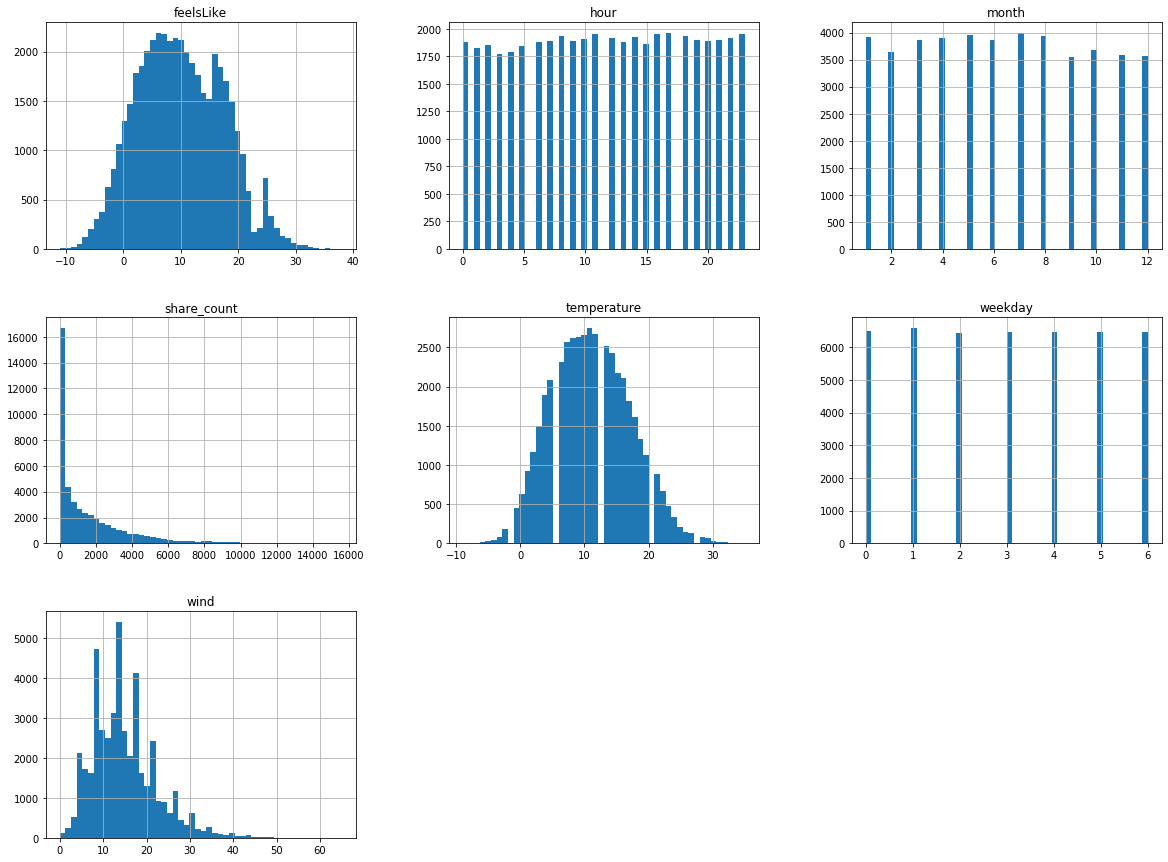

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
bike_share_df.hist(bins=50, figsize=(20,15))
plt.show()

Text(0.5, 1.0, 'Ungrouped weather codes')

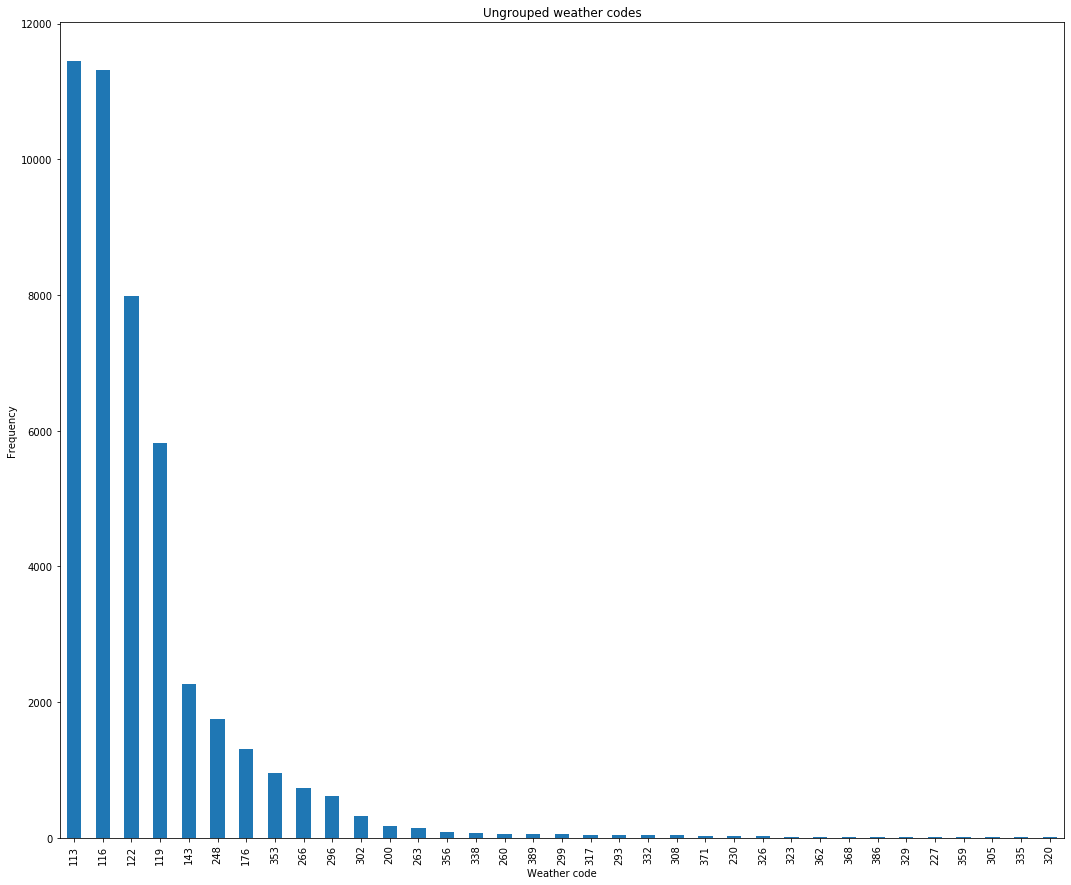

In [13]:
ax = bike_share_df['weatherCode'].value_counts().plot('bar', figsize=(18, 15))
ax.set_xlabel('Weather code')
ax.set_ylabel('Frequency')
ax.set_title('Ungrouped weather codes')

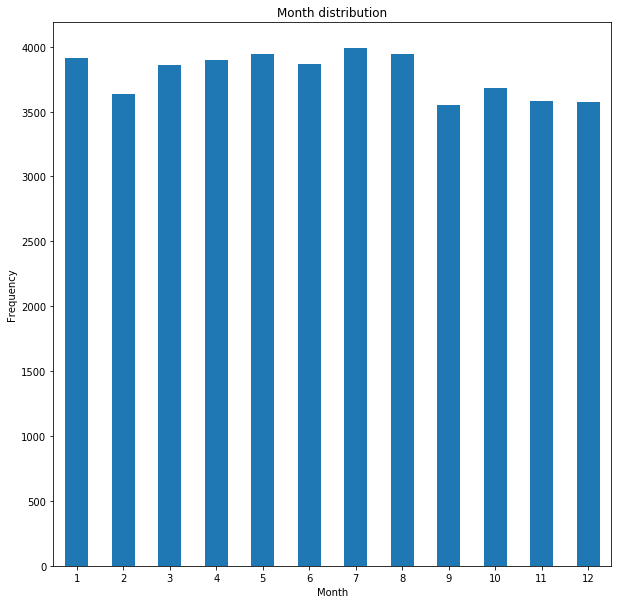

In [14]:
ax = bike_share_df['month'].value_counts(sort=False).plot('bar', figsize=(10,10))
ax.set_xlabel('Month')
ax.set_ylabel('Frequency')
ax.set_title('Month distribution')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

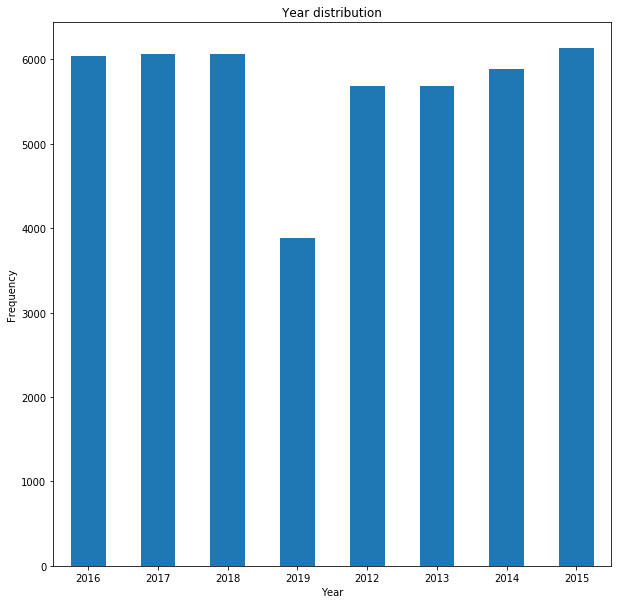

In [15]:
ax = bike_share_df['Start Date'].map(lambda x: x.year).value_counts(sort=False).plot('bar', figsize=(10,10))
ax.set_xlabel('Year')
ax.set_ylabel('Frequency')
ax.set_title('Year distribution')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

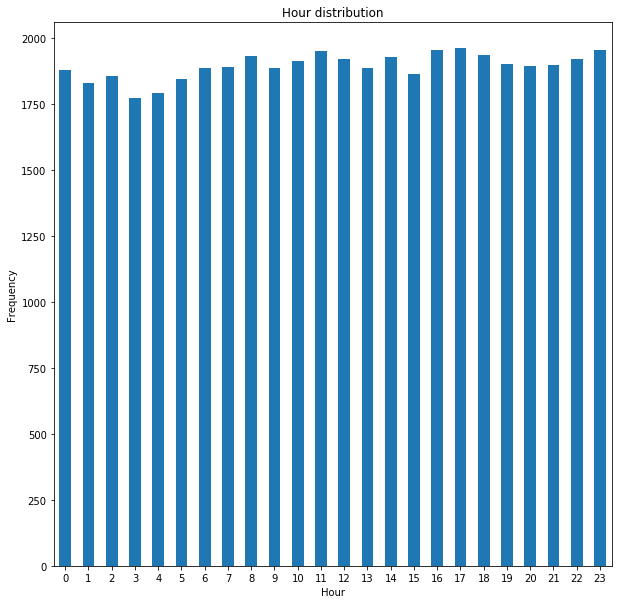

In [16]:
ax = bike_share_df['hour'].value_counts(sort=False).plot('bar', figsize=(10,10))
ax.set_xlabel('Hour')
ax.set_ylabel('Frequency')
ax.set_title('Hour distribution')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

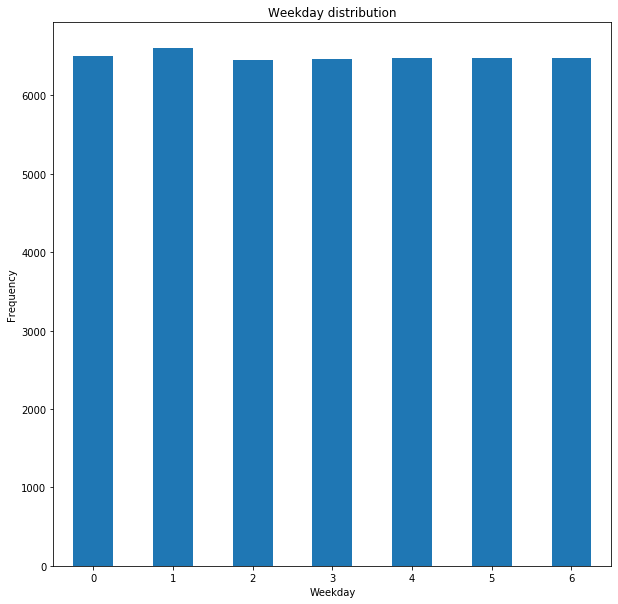

In [17]:
ax = bike_share_df['weekday'].value_counts(sort=False).plot('bar', figsize=(10,10))
ax.set_xlabel('Weekday')
ax.set_ylabel('Frequency')
ax.set_title('Weekday distribution')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

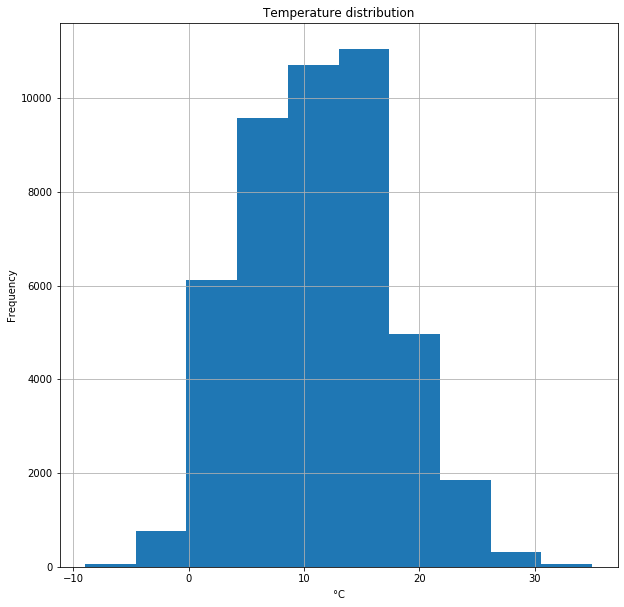

In [18]:
ax = bike_share_df['temperature'].hist(bins=10, figsize=(10,10))
ax.set_xlabel(r'$\degree$C')
ax.set_ylabel('Frequency')
_ = ax.set_title('Temperature distribution')

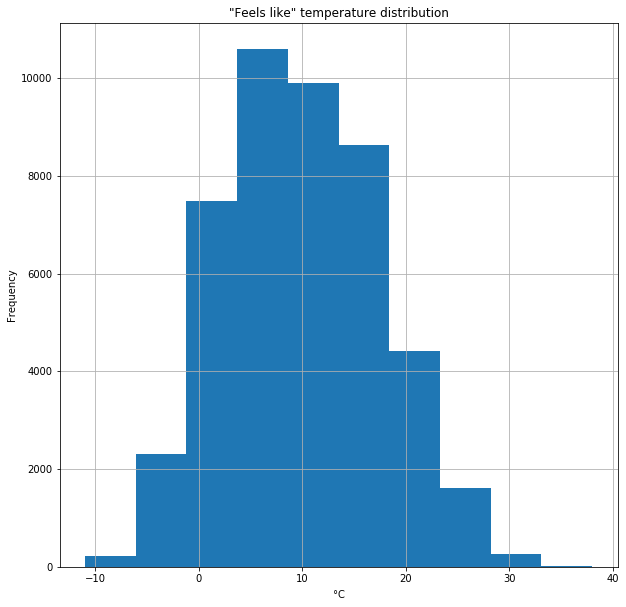

In [19]:
ax = bike_share_df['feelsLike'].hist(bins=10, figsize=(10,10))
ax.set_xlabel(r'$\degree$C')
ax.set_ylabel('Frequency')
_ = ax.set_title('"Feels like" temperature distribution')

In [20]:
bike_share_df[bike_share_df['share_count'] <= 100].shape

(10863, 11)

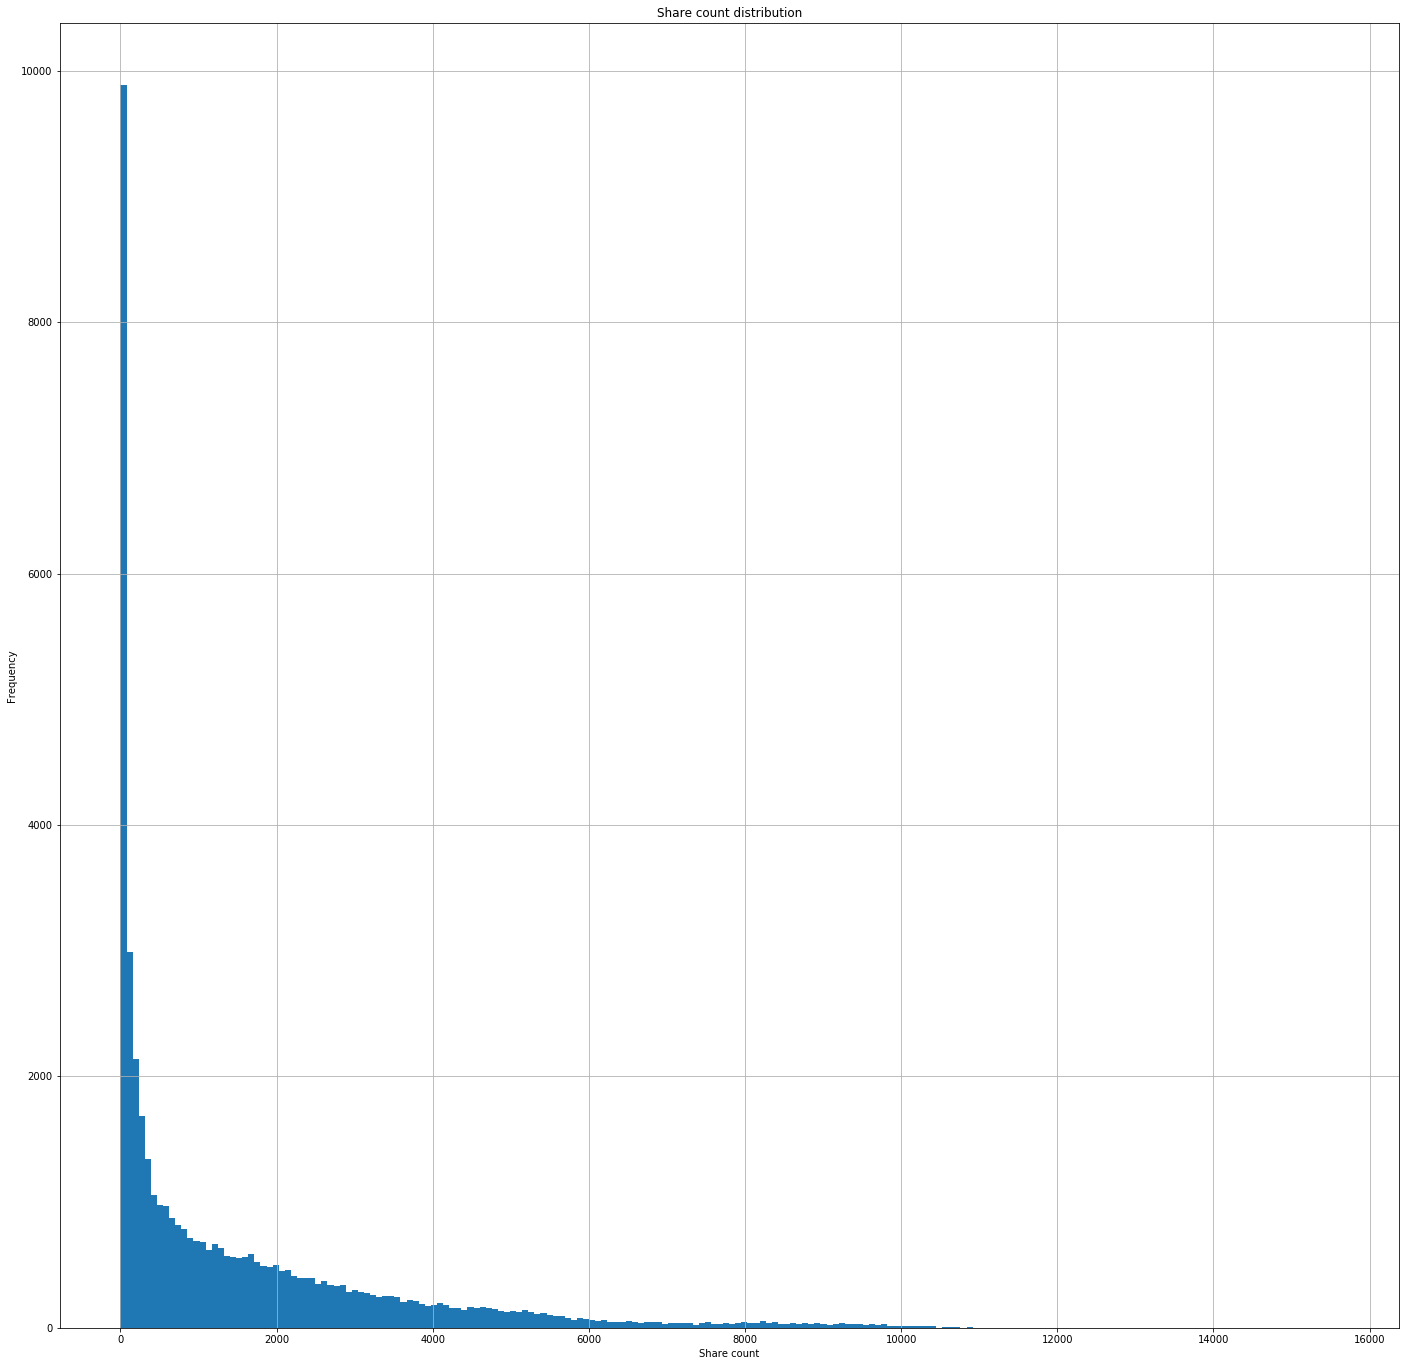

In [21]:
ax = bike_share_df['share_count'].hist(bins=200, figsize=(24,24))
ax.set_xlabel('Share count')
ax.set_ylabel('Frequency')
_ = ax.set_title('Share count distribution')

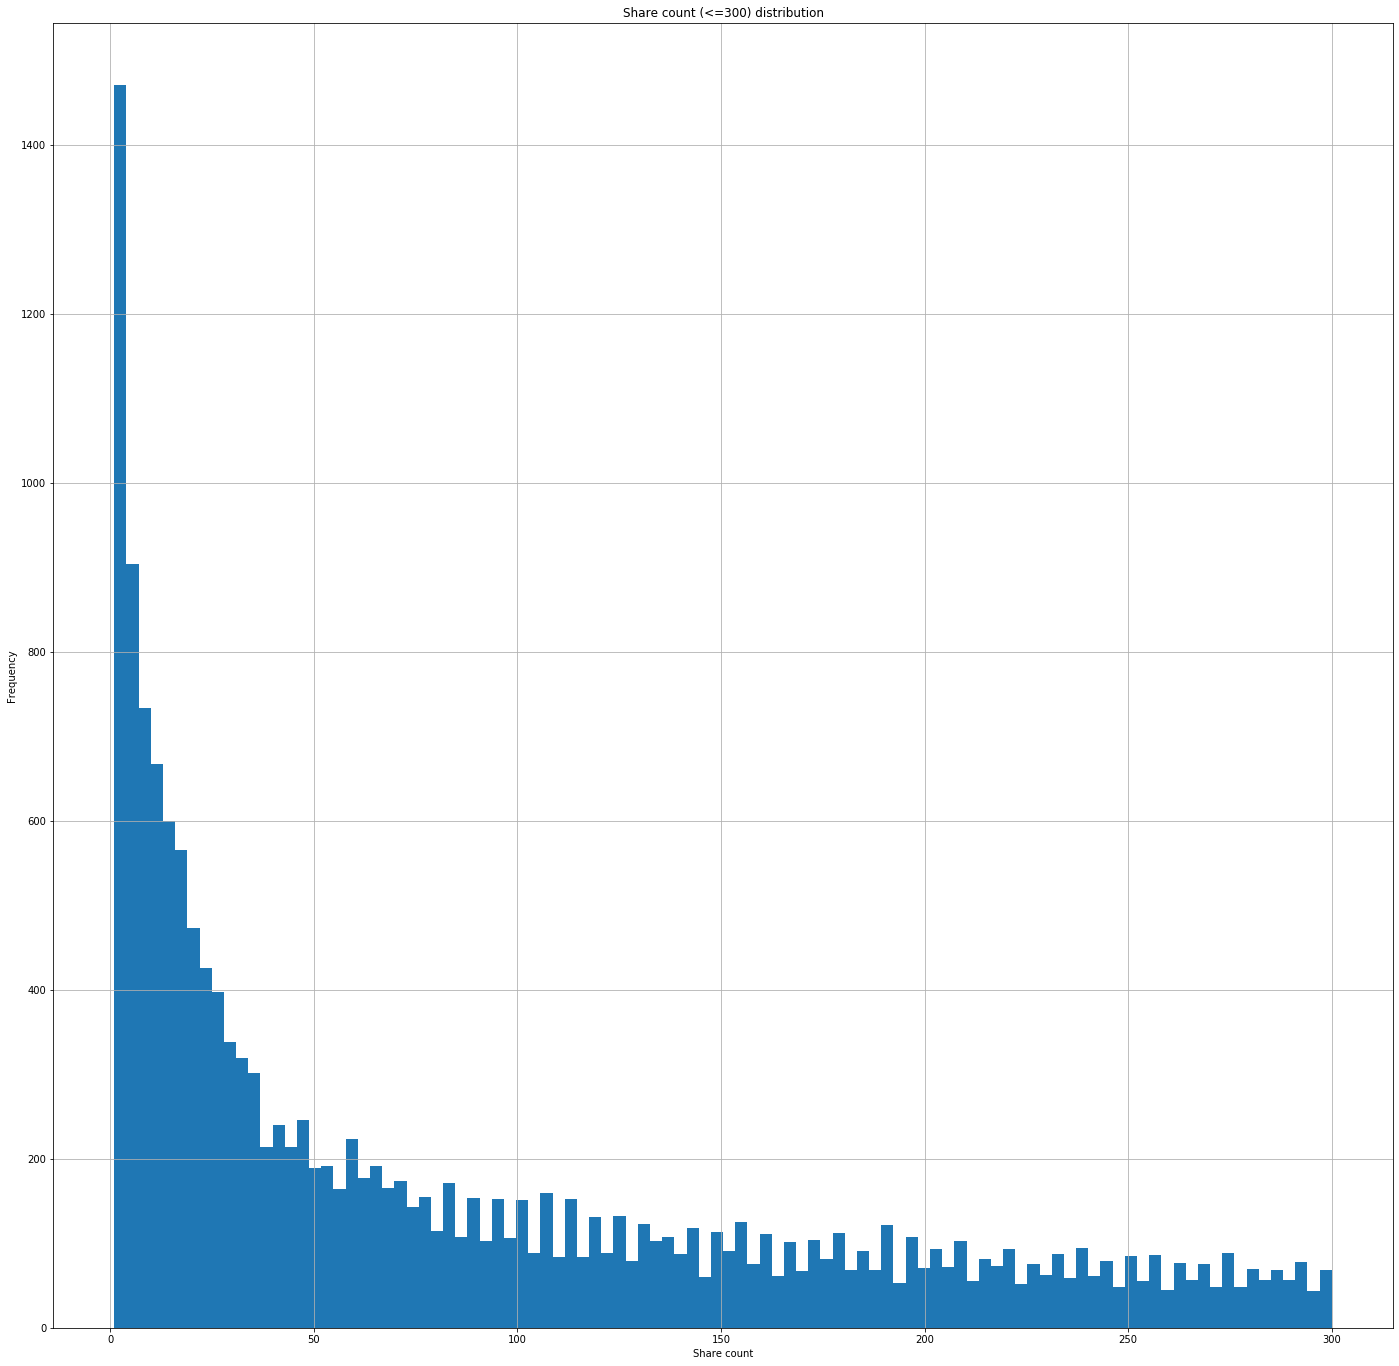

In [22]:
ax = bike_share_df[bike_share_df['share_count'] <= 300]['share_count'].hist(bins=100, figsize=(24,24))
ax.set_xlabel('Share count')
ax.set_ylabel('Frequency')
_ = ax.set_title('Share count (<=300) distribution')

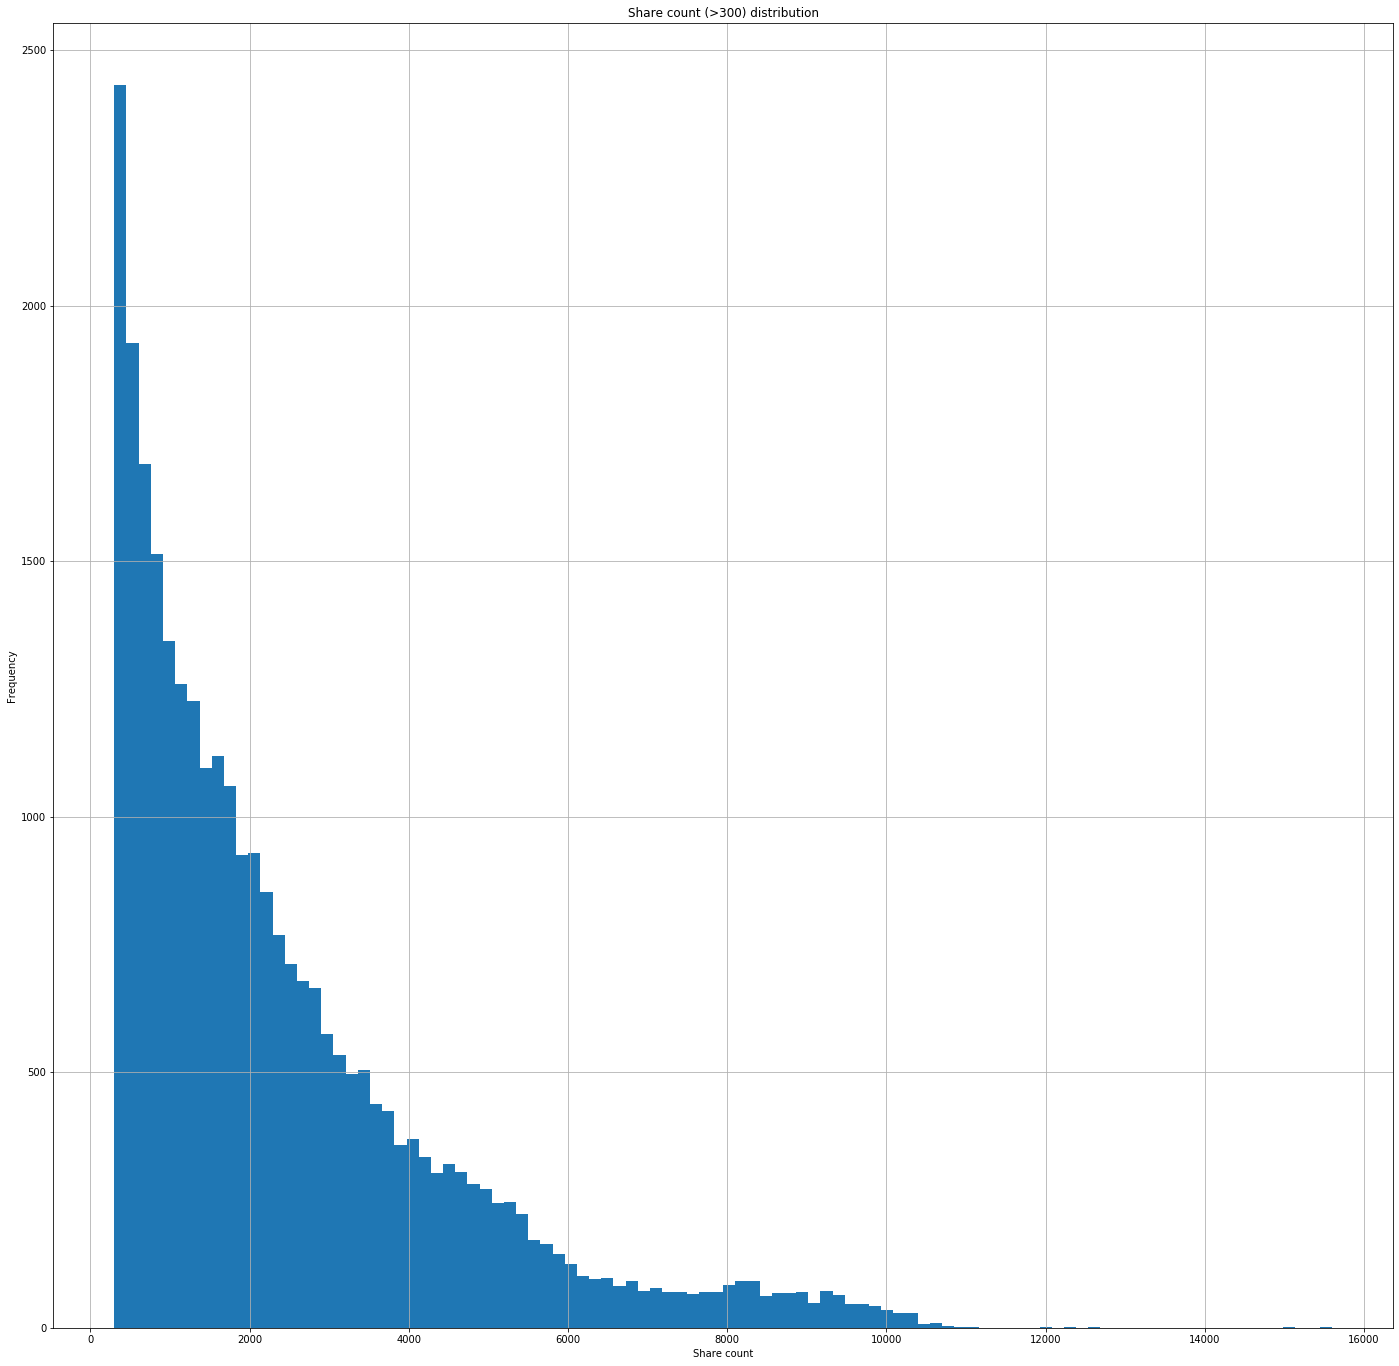

In [23]:
ax = bike_share_df[bike_share_df['share_count'] > 300]['share_count'].hist(bins=100, figsize=(24,24))
ax.set_xlabel('Share count')
ax.set_ylabel('Frequency')
_ = ax.set_title('Share count (>300) distribution')

#### Grouping weather codes

In [24]:
shares_extra_attribs = group_weather_codes(bike_share_df)

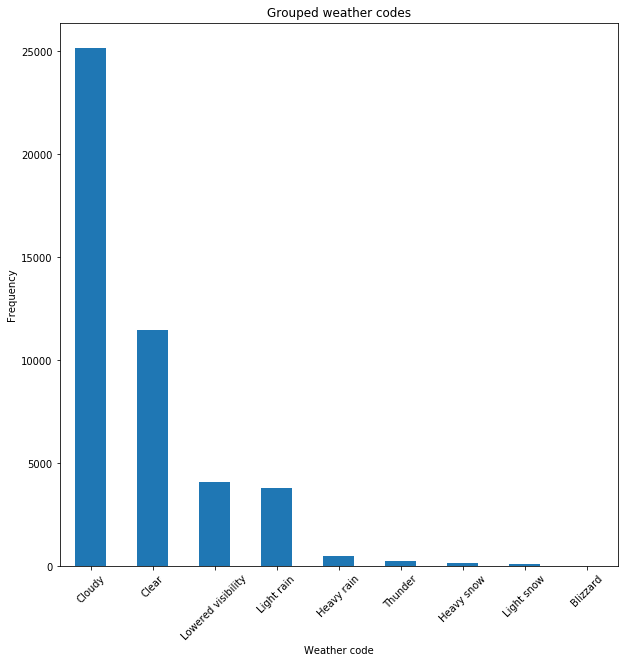

In [25]:
ax = shares_extra_attribs['weatherCode'].value_counts().plot('bar', figsize=(10,10))
ax.set_xlabel('Weather code')
ax.set_ylabel('Frequency')
ax.set_title('Grouped weather codes')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

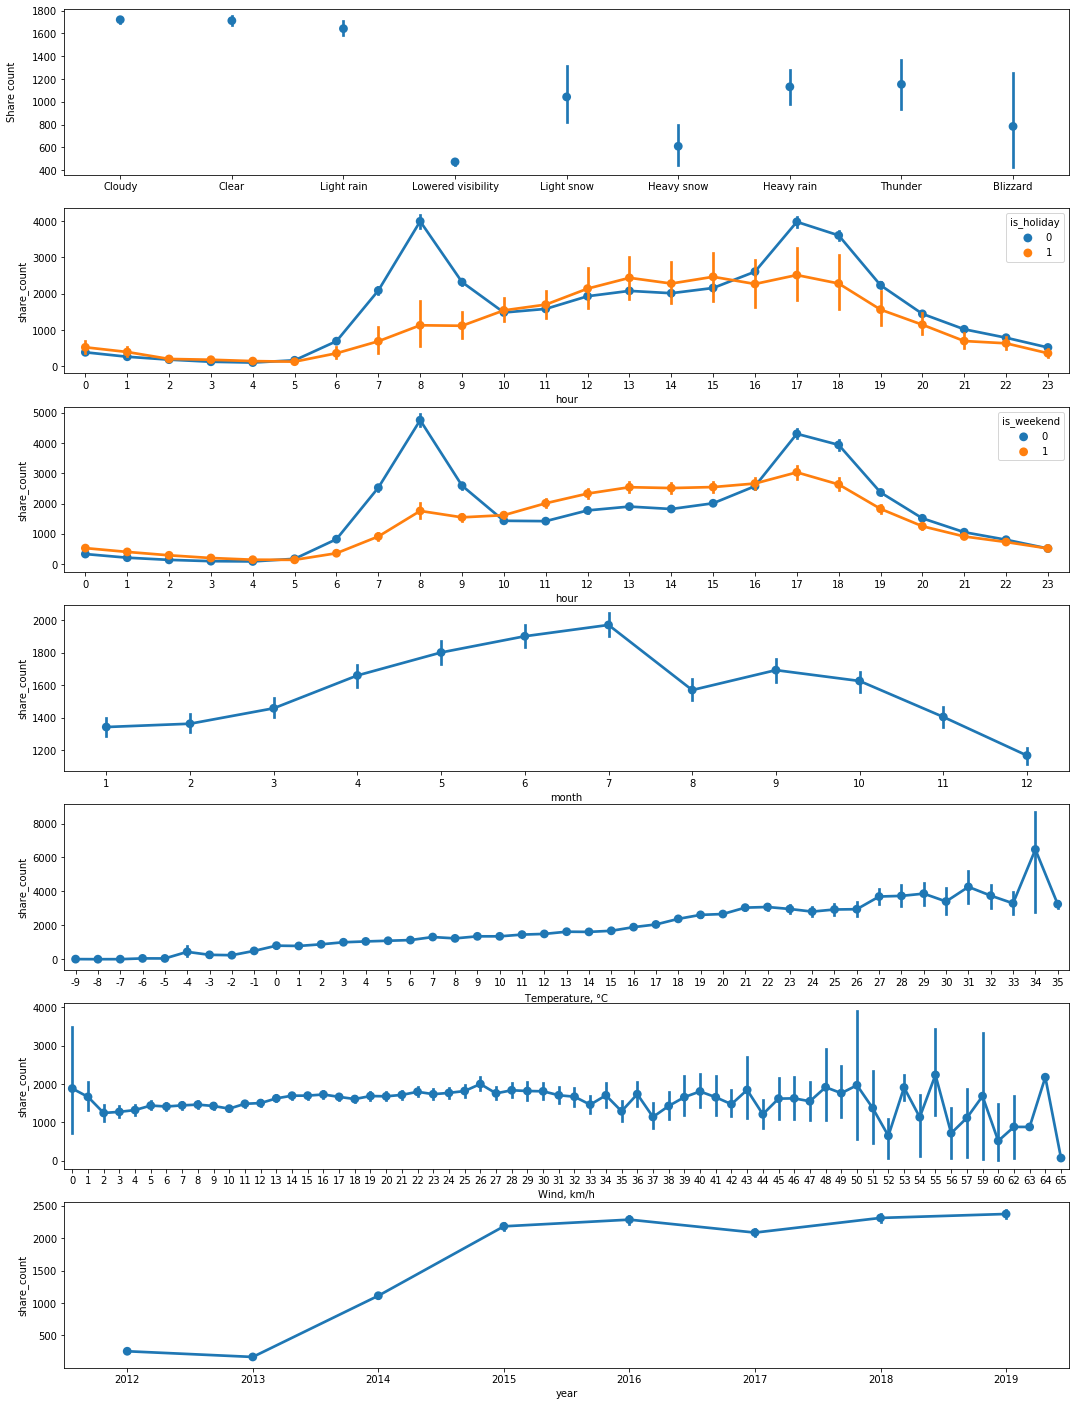

In [26]:
fig,(ax1, ax2, ax3, ax4, ax5, ax6, ax7)= plt.subplots(nrows=7)
fig.set_size_inches(fig_size)

sns.pointplot(data=shares_extra_attribs, x='weatherCode', y='share_count', ax=ax1, join=False)
sns.pointplot(data=shares_extra_attribs, x='hour', y='share_count', hue='is_holiday', ax=ax2)
sns.pointplot(data=shares_extra_attribs, x='hour', y='share_count', hue='is_weekend', ax=ax3)
sns.pointplot(data=shares_extra_attribs, x='month', y='share_count', ax=ax4)
temp_int = shares_extra_attribs.copy()
temp_int['temperature'] = temp_int['temperature'].map(int)
temp_int['wind'] = temp_int['wind'].map(int)
sns.pointplot(data=temp_int, x='temperature', y='share_count', ax=ax5)
ax5.set_xlabel(r'Temperature, $\degree$C')
sns.pointplot(data=temp_int, x='wind', y='share_count', ax=ax6)
ax6.set_xlabel('Wind, km/h')
ax1.set_xlabel('Weather code', labelpad=20)
_ = ax1.set_ylabel('Share count', labelpad=15)

temp_year = shares_extra_attribs.copy()
temp_year['year'] = temp_year['Start Date'].map(lambda x: x.year)
sns.pointplot(data=temp_year, x='year', y='share_count', ax=ax7)

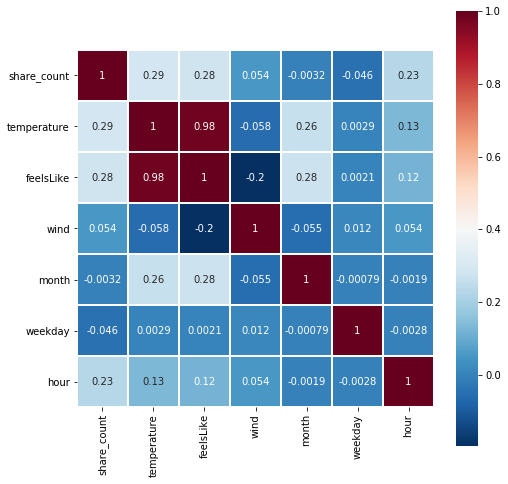

In [27]:
fig, ax= plt.subplots(nrows=1)
fig.set_size_inches(8,8)

pearsoncorr = bike_share_df.drop('Start Date', axis=1).corr(method='pearson')
heat_map = sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
            square=True,
            ax=ax)
_ = heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)

In [28]:
# save the dataset to analyse the improvevement with the cyclical data
df_non_cyc = shares_extra_attribs.copy().astype({
    'share_count': int,
    'temperature': float,
    'feelsLike': float,
    'wind': float})

# one-hot encode the data
# weather codes
encoded_weather_codes = pd.get_dummies(df_non_cyc['weatherCode'], prefix='weather')
df_non_cyc = df_non_cyc.drop(['weatherCode'], axis=1)
df_non_cyc = df_non_cyc.join(encoded_weather_codes)
# holiday & weekend
holiday_enc = pd.get_dummies(df_non_cyc['is_holiday'], prefix='holiday')
week_enc = pd.get_dummies(df_non_cyc['is_weekend'], prefix='weekend')
df_non_cyc = df_non_cyc.join(holiday_enc).join(week_enc)
df_non_cyc = df_non_cyc.drop(['is_holiday', 'is_weekend'], axis=1)
# hours
encoded_hours = pd.get_dummies(df_non_cyc['hour'], prefix='hour')
df_non_cyc = df_non_cyc.drop(['hour'], axis=1)
df_non_cyc = df_non_cyc.join(encoded_hours)
# month
encoded_months = pd.get_dummies(df_non_cyc['month'], prefix='month')
df_non_cyc = df_non_cyc.drop(['month'], axis=1)
df_non_cyc = df_non_cyc.join(encoded_months)
# "weekday" is dropped due to the fact that we have "is_weekend"
df_non_cyc = df_non_cyc.drop(['weekday'], axis=1)
df_non_cyc = shuffle(df_non_cyc, random_state=random_state).reset_index(drop=True)

# now the same for test data...
non_cyc_test_set = group_weather_codes(test_set.copy())
# one-hot encode the data
# weather codes
encoded_weather_codes = pd.get_dummies(non_cyc_test_set['weatherCode'], prefix='weather')
non_cyc_test_set = non_cyc_test_set.drop(['weatherCode'], axis=1)
non_cyc_test_set = non_cyc_test_set.join(encoded_weather_codes)
# holiday & weekend
holiday_enc = pd.get_dummies(non_cyc_test_set['is_holiday'], prefix='holiday')
week_enc = pd.get_dummies(non_cyc_test_set['is_weekend'], prefix='weekend')
non_cyc_test_set = non_cyc_test_set.join(holiday_enc).join(week_enc)
non_cyc_test_set = non_cyc_test_set.drop(['is_holiday', 'is_weekend'], axis=1)
# hours
encoded_hours = pd.get_dummies(non_cyc_test_set['hour'], prefix='hour')
non_cyc_test_set = non_cyc_test_set.drop(['hour'], axis=1)
non_cyc_test_set = non_cyc_test_set.join(encoded_hours)
# month
encoded_months = pd.get_dummies(non_cyc_test_set['month'], prefix='month')
non_cyc_test_set = non_cyc_test_set.drop(['month'], axis=1)
non_cyc_test_set = non_cyc_test_set.join(encoded_months)
# "weekday" is dropped due to the fact that we have "is_weekend"
non_cyc_test_set = non_cyc_test_set.drop(['weekday'], axis=1)

### Dealing with cyclical data

In [29]:
types = {
    'weatherCode': str,
    'is_holiday': str,
    'is_weekend': str,
    'share_count': int,
    'temperature': float,
    'feelsLike': float,
    'wind': float,
    'hr_sin': float,
    'hr_cos': float,
    'mnth_sin': float,
    'mnth_cos': float
}

shares_extra_attribs = convert_cyclical_data(shares_extra_attribs)
shares_extra_attribs = shares_extra_attribs.astype(types)

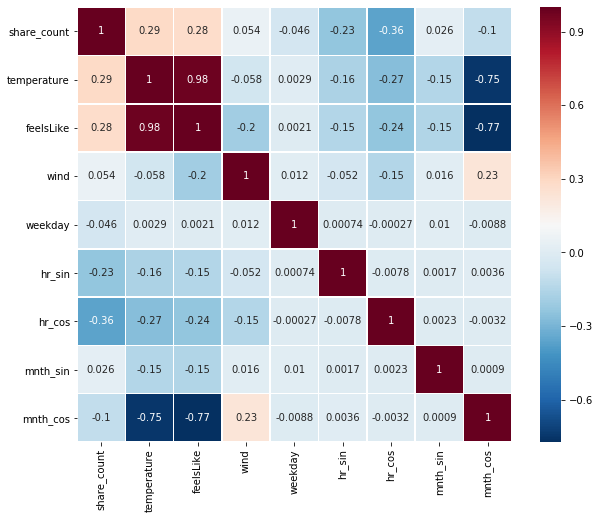

In [30]:
fig, ax= plt.subplots(nrows=1)
fig.set_size_inches(10,8)

pearsoncorr = shares_extra_attribs.drop('Start Date', axis=1).corr(method='pearson')
heat_map=sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
            square=True,
            ax=ax)
_ = heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)

### Adding lag value

In [31]:
types = {
    **types,
    'lag_1': int,
#     'lag_2': int,
#     'lag_3': int
}

shares_extra_attribs = add_lag_value(shares_extra_attribs, count=1)
shares_extra_attribs = shares_extra_attribs.astype(types)

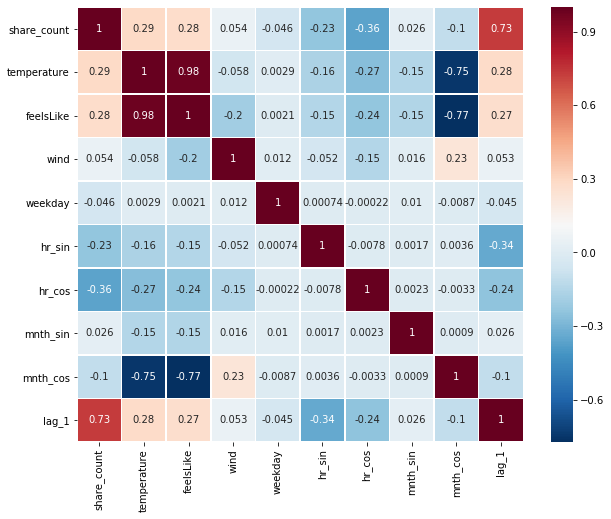

In [32]:
fig, ax= plt.subplots(nrows=1)
fig.set_size_inches(10,8)

pearsoncorr = shares_extra_attribs.drop('Start Date', axis=1).corr(method='pearson')
heat_map=sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
            ax=ax)
_ = heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)

### Transform data for the model

In [33]:
types = {
    'weatherCode': str,
    'is_holiday': str,
    'is_weekend': str,
    'share_count': int,
    'temperature': float,
    'feelsLike': float,
    'wind': float,
    'hr_sin': float,
    'hr_cos': float,
    'mnth_sin': float,
    'mnth_cos': float,
    'lag_1': int,
#     'lag_2': int,
#     'lag_3': int,
}
def transform_data(df_, add_lag=True, lag_count=1):
    df_ = df_.copy()
    df_ = group_weather_codes(df_)
    df_ = convert_cyclical_data(df_)
    if add_lag:
        df_ = add_lag_value(df_, count=lag_count)
    # one-hot encode the data
    # weather codes
    encoded_weather_codes = pd.get_dummies(df_['weatherCode'], prefix='weather')
    df_ = df_.drop(['weatherCode'], axis=1)
    df_ = df_.join(encoded_weather_codes)
    # holiday & weekend
    holiday_enc = pd.get_dummies(df_['is_holiday'], prefix='holiday')
    week_enc = pd.get_dummies(df_['is_weekend'], prefix='weekend')
    df_ = df_.join(holiday_enc).join(week_enc)
    df_ = df_.drop(['is_holiday', 'is_weekend'], axis=1)
    # "weekday" is dropped due to the fact that we have "is_weekend"
    df_ = df_.drop(['weekday'], axis=1)
    return df_

#### Data with lag value

In [34]:
# transform the data
bike_share_df_enc = transform_data(bike_share_df.sort_values('Start Date'))
# shuffle the dataframe
bike_share_df_enc = shuffle(bike_share_df_enc, random_state=random_state).reset_index(drop=True)
# transform the data
test_set_lag = transform_data(test_set.sort_values('Start Date'))
# shuffle the test data
test_set_lag = shuffle(test_set_lag, random_state=random_state).reset_index(drop=True)

#### Data without lag value

In [35]:
# transform the data
df_enc_no_lag = transform_data(bike_share_df.sort_values('Start Date'), add_lag=False)
# shuffle the dataframe
df_enc_no_lag = shuffle(df_enc_no_lag, random_state=random_state).reset_index(drop=True)
# transform the data
test_set_no_lag = transform_data(test_set.sort_values('Start Date'), add_lag=False)
# shuffle the test data
test_set_no_lag = shuffle(test_set_no_lag, random_state=random_state).reset_index(drop=True)

### Training models with lag data

In [36]:
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

def create_models(prefix=''):
    return [
        ('blue', f'{prefix} Random Forest', RandomForestRegressor(random_state=random_state)),
        ('blue', f'{prefix} Random Forest optimized', RandomForestRegressor(n_estimators=1000, random_state=random_state)),
        ('orange', f'{prefix} GradientBoostRegressor', GradientBoostingRegressor(random_state=random_state, max_depth=8)),
        ('orange', f'{prefix} GradientBoostRegressor optimized', GradientBoostingRegressor(loss='huber', n_estimators=160, random_state=random_state, max_depth=8)),
        ('red', f'{prefix} MLPRegressor', MLPRegressor(random_state=random_state)),
        ('red', f'{prefix} MLPRegressor optimized', MLPRegressor(alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate='constant', n_iter_no_change=50, solver='adam', random_state=random_state))
    ]

def learn(models, X_train, Y_train, X_test, Y_test):
    mdl_results = []
    for color, name, mdl in models:
        print(f'** {name}')
        t0 = time.time()
        mdl.fit(X_train, Y_train)
        t1 = time.time()
        score_train = mdl.score(X_train[:10000], Y_train[:10000])
        t2 = time.time()
        score_test = mdl.score(X_test, Y_test)
        t3 = time.time()
        
        results = mdl.predict(X_test)
        mdl_results.append({'name': name, 'results': results, 'color': color})
        
        MAE = mean_absolute_error(Y_test, results)
        RMSE = np.sqrt(mean_squared_error(Y_test, results))
        R2 = r2_score(Y_test, results)

        print(f'\tTraining time {t1 - t0:3.3f}')
        print(f'\tPrediction time (train) {t2 - t1:3.3f}')
        print(f'\tPrediction time (test) {t3 - t2:3.3f}')
        print(f'\tMean absolute error {MAE}')
        print(f'\tRoot mean squared error {RMSE}')
        print(f'\tR2 score {R2}')
        print(f'\tScore train: {score_train:.3f}\tScore Test: {score_test:.3f}')
    return mdl_results

In [37]:
train_set_lag = bike_share_df_enc.drop('Start Date', axis=1)
test_set_lag_ = test_set_lag.drop('Start Date', axis=1)

X_train_lag = train_set_lag.drop('share_count', axis=1).to_numpy()
Y_train_lag = train_set_lag['share_count'].to_numpy()

X_test_lag = test_set_lag_.drop('share_count', axis=1).to_numpy()
Y_test_lag = test_set_lag_['share_count'].to_numpy()

In [38]:
models_lag = create_models('Lag')

In [39]:
# results with lag data
final_results_lag = learn(models_lag, X_train_lag, Y_train_lag, X_test_lag, Y_test_lag)

** Lag Random Forest


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


	Training time 1.605
	Prediction time (train) 0.023
	Prediction time (test) 0.040
	Mean absolute error 603.4976188519678
	Root mean squared error 1208.2877465490874
	R2 score 0.622735677071723
	Score train: 0.976	Score Test: 0.623
** Lag Random Forest optimized
	Training time 159.826
	Prediction time (train) 2.230
	Prediction time (test) 3.871
	Mean absolute error 587.2460031404456
	Root mean squared error 1182.0145214506217
	R2 score 0.6389639089527115
	Score train: 0.983	Score Test: 0.639
** Lag GradientBoostRegressor
	Training time 16.796
	Prediction time (train) 0.029
	Prediction time (test) 0.057
	Mean absolute error 584.2566082208557
	Root mean squared error 1158.5091605003336
	R2 score 0.6531801558955387
	Score train: 0.930	Score Test: 0.653
** Lag GradientBoostRegressor optimized
	Training time 27.043
	Prediction time (train) 0.039
	Prediction time (test) 0.075
	Mean absolute error 595.6459509935862
	Root mean squared error 1222.4546394692675
	R2 score 0.6138371415233788
	Score

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	Training time 18.065
	Prediction time (train) 0.007
	Prediction time (test) 0.014
	Mean absolute error 811.2379531180695
	Root mean squared error 1440.4230669210567
	R2 score 0.46385145784738113
	Score train: 0.676	Score Test: 0.464
** Lag MLPRegressor optimized


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	Training time 98.726
	Prediction time (train) 0.041
	Prediction time (test) 0.088
	Mean absolute error 610.4318557835629
	Root mean squared error 1160.8587892499283
	R2 score 0.6517719249182617
	Score train: 0.880	Score Test: 0.652


In [40]:
# # Search through param_grid parameters, find the best set of parameters for GBR (Gradient Boosting Regressor)
# param_grid = [
#     {'max_features': [21], 'max_depth': [3, 10, 20, 50, 100]}
#   ]

# mdl = GradientBoostingRegressor(random_state=random_state)

# grid_search = GridSearchCV(mdl, param_grid, cv=5,
#                            scoring='neg_mean_squared_error', return_train_score=True)
# grid_search.fit(X_train, Y_train)

# # Run GBR with best set of parameters
# mdl = GradientBoostingRegressor(random_state=random_state,
#                                 **grid_search.best_params_,
#                                 n_estimators=2000)

# mdl.fit(X_train, Y_train)
# results = mdl.predict(X_test)
# score = mdl.score(X_test, Y_test)
# print("TEST SCORE: " + str(score))

In [41]:
X_train_lag.shape, X_test_lag.shape

((45431, 21), (19471, 21))

In [42]:
# the models also predict negative values
results = final_results_lag[-1]['results']
# count negative
results[results < 0].shape

(395,)

### Training the model without lag data

In [43]:
train_set_no_lag = df_enc_no_lag.drop('Start Date', axis=1)
test_set_no_lag_ = test_set_no_lag.drop('Start Date', axis=1)

X_train_no_lag = train_set_no_lag.drop('share_count', axis=1).to_numpy()
Y_train_no_lag = train_set_no_lag['share_count'].to_numpy()

X_test_no_lag = test_set_no_lag_.drop('share_count', axis=1).to_numpy()
Y_test_no_lag = test_set_no_lag_['share_count'].to_numpy()

In [44]:
models_no_lag = create_models('No lag')

In [45]:
no_lag_results = learn(models_no_lag, X_train_no_lag, Y_train_no_lag, X_test_no_lag, Y_test_no_lag)

** No lag Random Forest


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


	Training time 1.105
	Prediction time (train) 0.024
	Prediction time (test) 0.041
	Mean absolute error 957.0787571205213
	Root mean squared error 1531.2879626472543
	R2 score 0.3940632561570615
	Score train: 0.875	Score Test: 0.394
** No lag Random Forest optimized
	Training time 109.091
	Prediction time (train) 2.288
	Prediction time (test) 4.058
	Mean absolute error 931.883904099272
	Root mean squared error 1482.0118412058594
	R2 score 0.4324333102839134
	Score train: 0.908	Score Test: 0.432
** No lag GradientBoostRegressor
	Training time 14.837
	Prediction time (train) 0.031
	Prediction time (test) 0.059
	Mean absolute error 899.9138025178336
	Root mean squared error 1404.7349650509932
	R2 score 0.49007965885533344
	Score train: 0.613	Score Test: 0.490
** No lag GradientBoostRegressor optimized
	Training time 27.876
	Prediction time (train) 0.045
	Prediction time (test) 0.086
	Mean absolute error 885.5657067782633
	Root mean squared error 1415.7768178590782
	R2 score 0.4820317430636

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	Training time 16.811
	Prediction time (train) 0.004
	Prediction time (test) 0.007
	Mean absolute error 1096.5513470443043
	Root mean squared error 1575.471769270694
	R2 score 0.3585913645603618
	Score train: 0.370	Score Test: 0.359
** No lag MLPRegressor optimized


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	Training time 107.569
	Prediction time (train) 0.060
	Prediction time (test) 0.116
	Mean absolute error 924.1870526672233
	Root mean squared error 1436.2580752065396
	R2 score 0.46693702517468616
	Score train: 0.512	Score Test: 0.467


### Training models with encoded hour and month, without lag data

In [46]:
train_set_non_cyc = df_non_cyc.drop('Start Date', axis=1)
test_set_non_cyc = non_cyc_test_set.drop('Start Date', axis=1)

X_train_non_cyc = train_set_non_cyc.drop('share_count', axis=1).to_numpy()
Y_train_non_cyc = train_set_non_cyc['share_count'].to_numpy()

X_test_non_cyc = test_set_non_cyc.drop('share_count', axis=1).to_numpy()
Y_test_non_cyc = test_set_non_cyc['share_count'].to_numpy()

In [47]:
models_non_cyc = create_models('No cyclical')

In [48]:
non_cyc_results = learn(models_non_cyc, X_train_non_cyc, Y_train_non_cyc, X_test_non_cyc, Y_test_non_cyc)

** No cyclical Random Forest


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


	Training time 1.969
	Prediction time (train) 0.027
	Prediction time (test) 0.045
	Mean absolute error 1013.1585255548057
	Root mean squared error 1608.0781540971498
	R2 score 0.33176709737758836
	Score train: 0.869	Score Test: 0.332
** No cyclical Random Forest optimized
	Training time 186.186
	Prediction time (train) 2.355
	Prediction time (test) 4.334
	Mean absolute error 978.0123064903264
	Root mean squared error 1541.7266150814382
	R2 score 0.38577386545459036
	Score train: 0.901	Score Test: 0.386
** No cyclical GradientBoostRegressor
	Training time 23.637
	Prediction time (train) 0.022
	Prediction time (test) 0.042
	Mean absolute error 944.6589778048414
	Root mean squared error 1444.2268597651473
	R2 score 0.46100543352140577
	Score train: 0.601	Score Test: 0.461
** No cyclical GradientBoostRegressor optimized
	Training time 40.375
	Prediction time (train) 0.035
	Prediction time (test) 0.065
	Mean absolute error 930.9105454778866
	Root mean squared error 1463.3463617690866
	R2 sc

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	Training time 20.596
	Prediction time (train) 0.005
	Prediction time (test) 0.009
	Mean absolute error 981.972706977104
	Root mean squared error 1466.6781188560922
	R2 score 0.44411727556685865
	Score train: 0.449	Score Test: 0.444
** No cyclical MLPRegressor optimized


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	Training time 118.801
	Prediction time (train) 0.080
	Prediction time (test) 0.160
	Mean absolute error 908.9390695904419
	Root mean squared error 1425.6412190338558
	R2 score 0.4747887276258228
	Score train: 0.557	Score Test: 0.475


### Plotting a data range

In [49]:
def show_range(models, start, range_, show_dates=False, **kwargs):
    # kwargs is passed to transform_data() function
    plot_results = []
    # transform the data
    test_data = transform_data(test_set_with_dates.copy(), **kwargs).iloc[start:start+range_]

    X_test_ = test_data.drop(['Start Date', 'share_count'], axis=1).to_numpy()
    Y_test_ = test_data['share_count'].to_numpy()

    for clr, name, mdl in models:
        results = mdl.predict(X_test_)
        plot_results.append({'name': name, 'results': results, 'color': clr})

    fig, ax= plt.subplots(nrows=1)
    fig.set_size_inches(20,15)
    font_final = {'size': 15, 'weight': 'normal'}
    plt.rc('font', **font_final)

    for result in plot_results:
        if 'optimized' in result['name']:
            line = plt.plot(result['results'], color=result['color'], label=result['name'].strip('optimized'))

    true_line = plt.plot(Y_test_, color='green', label='True value')
    # plt.axvspan(18, 21, color='grey', alpha=0.5)

    if show_dates:
        plt.xticks(list(range(len(test_data))), labels=test_data['Start Date'].map(str).values, rotation='vertical')
        plt.xlabel('Hour')
    plt.ylabel('Share count')
    plt.legend()
    plt.show()

#### Lag models

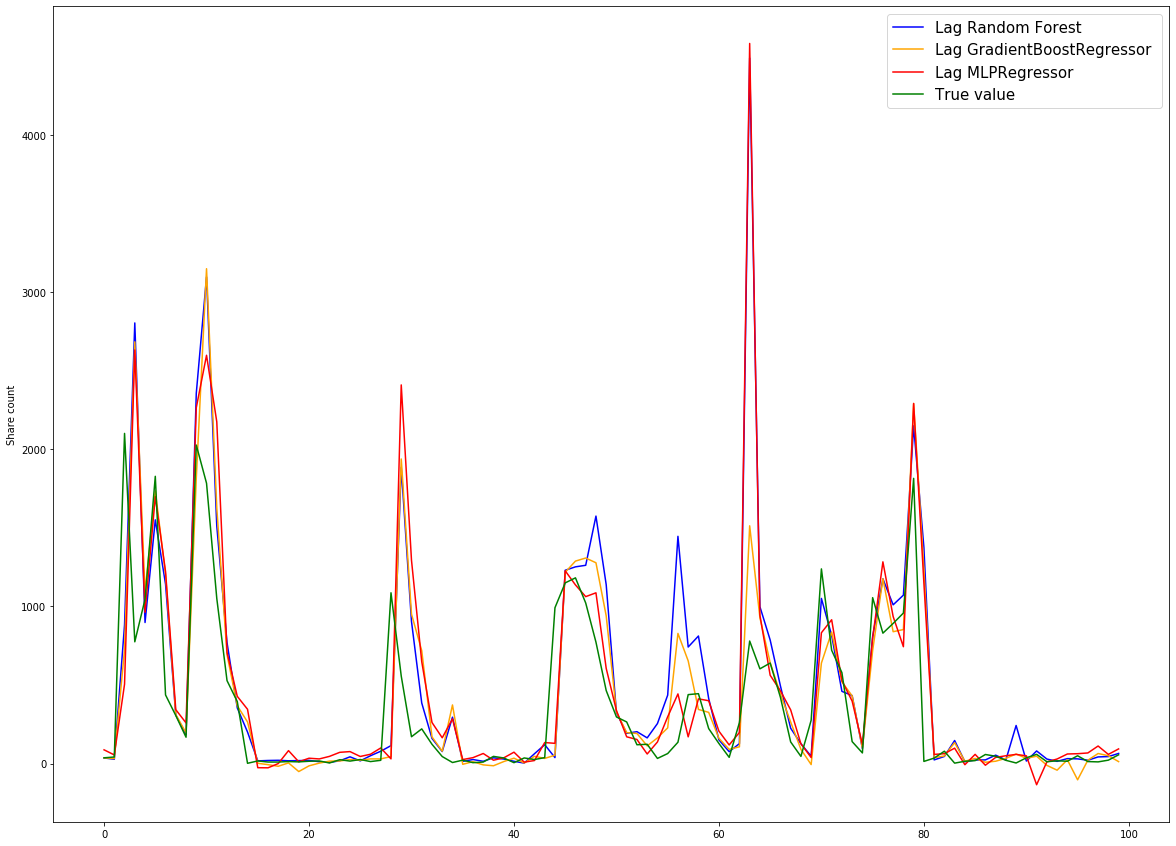

In [50]:
show_range(models_lag, 1000, 100)

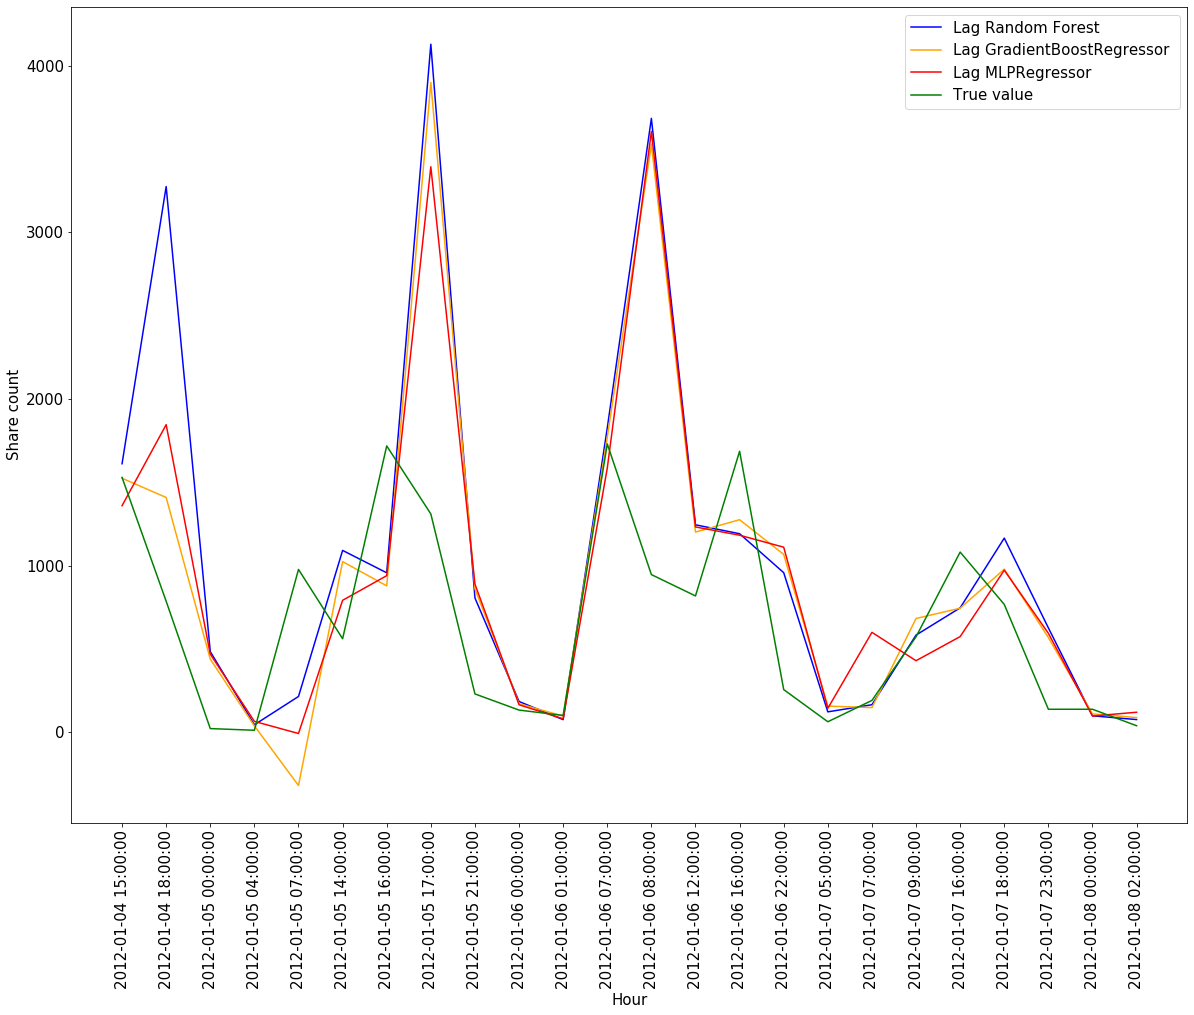

In [51]:
show_range(models_lag, 15, 24, True)

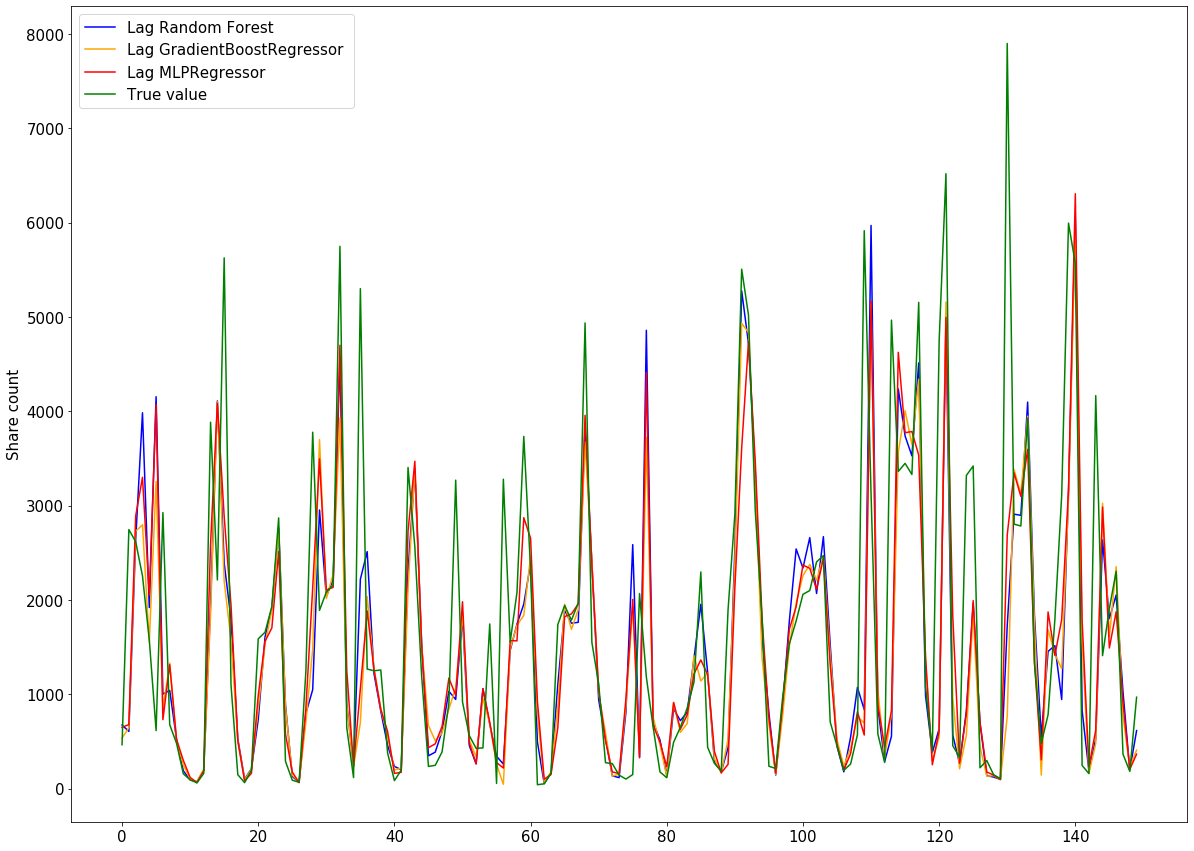

In [52]:
show_range(models_lag, 8000, 150)

#### No lag models

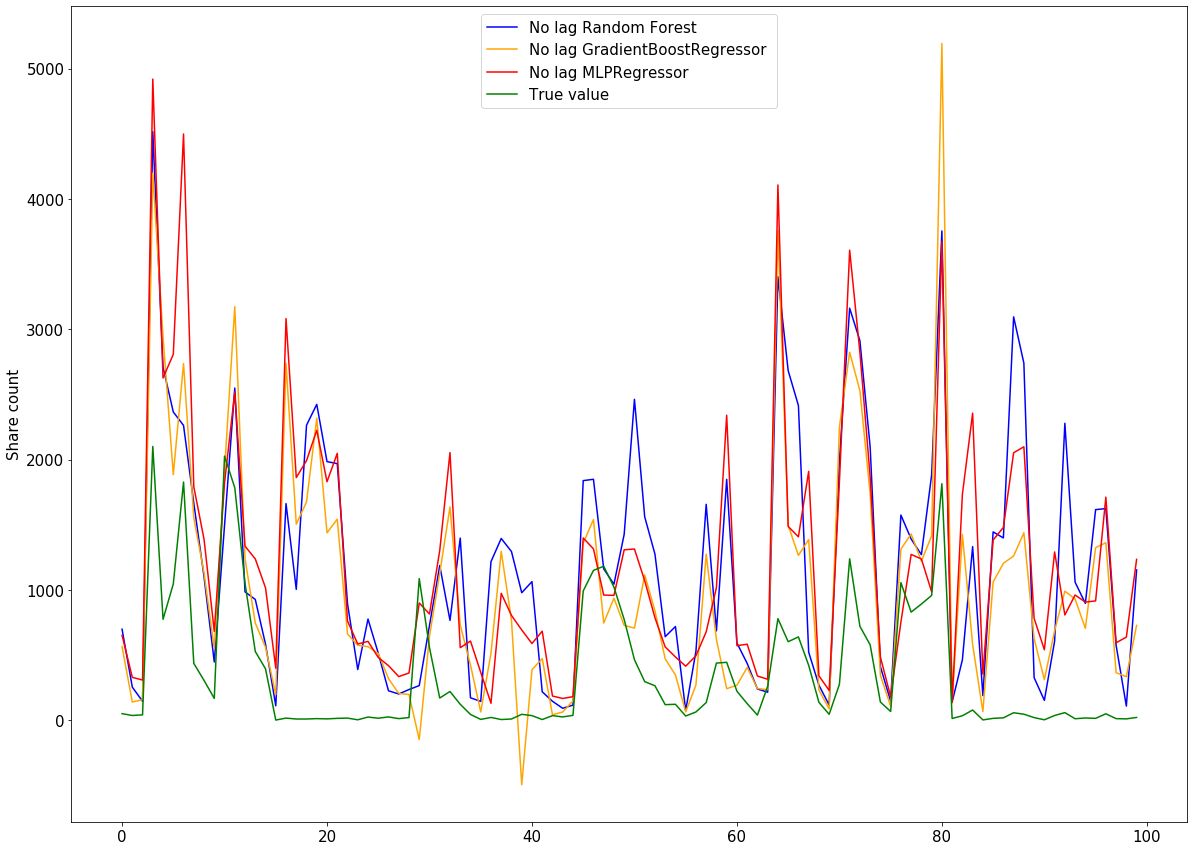

In [53]:
show_range(models_no_lag, 1000, 100, add_lag=False)

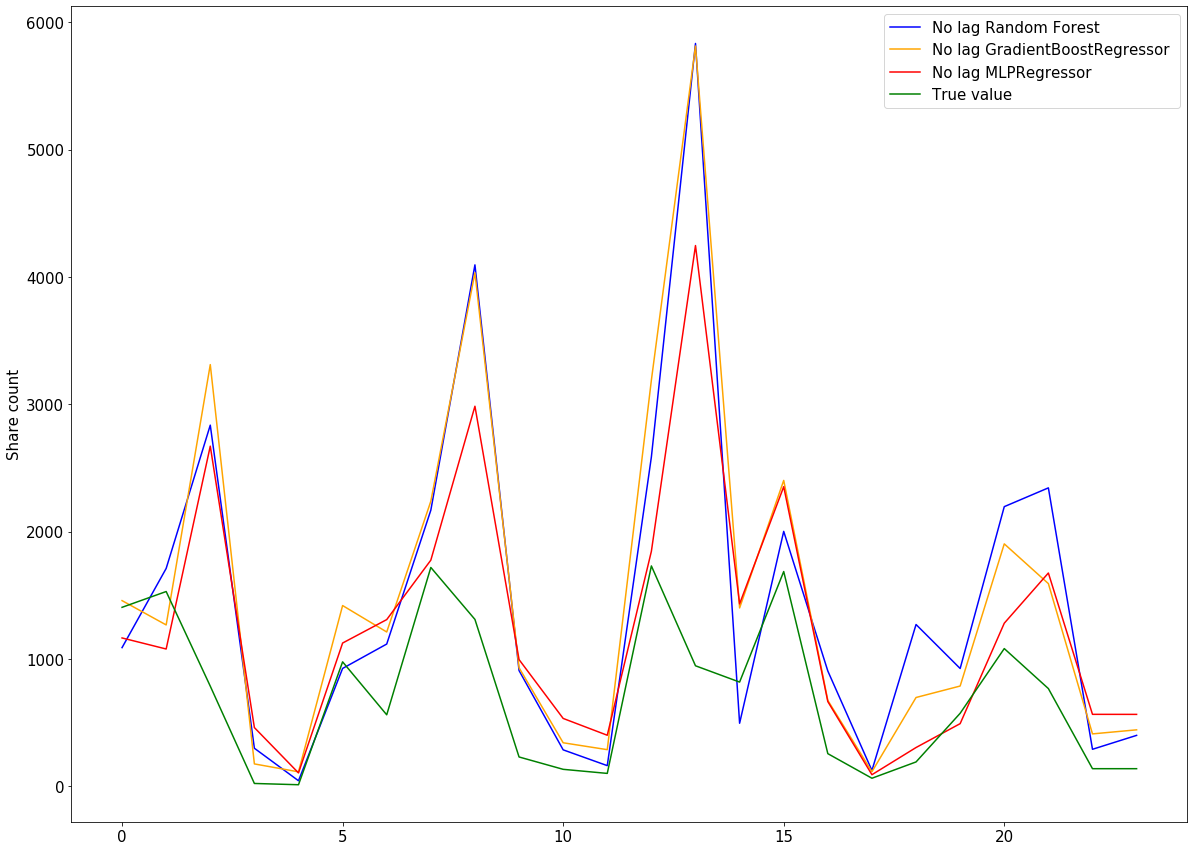

In [54]:
show_range(models_no_lag, 15, 24, add_lag=False)

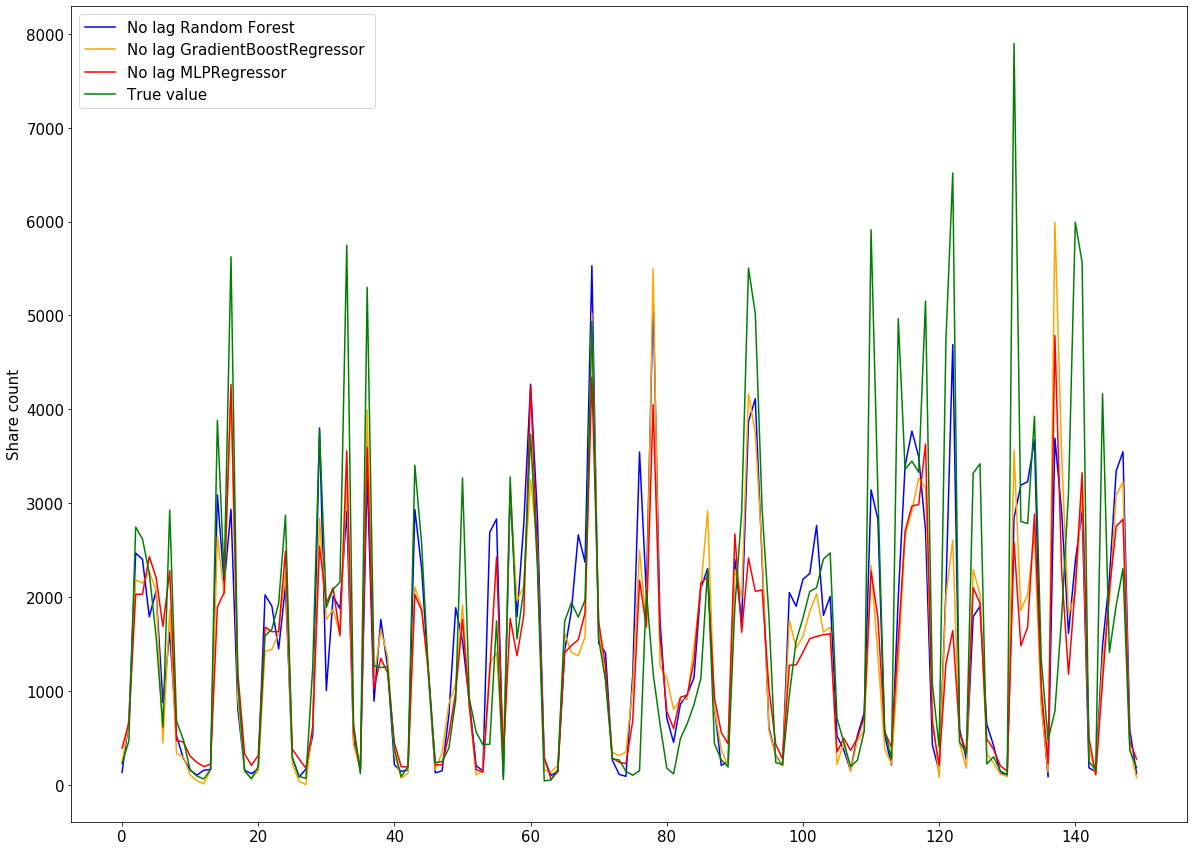

In [55]:
show_range(models_no_lag, 8000, 150, add_lag=False)